In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## Patient emotional state remains unaffected by the intervention



In [2]:
from environment.fogg_behavioural_model import Patient 

Basic enviroment where the patients emotional state and sleep pattern remains unchanged by the prompts.
Here we are intenting just to figure out when prompt is effective and learn optimal difficulty of activity. 

In [3]:
testPatient = Patient(20, True)

In [4]:
testPatient.get_ability(1)

1

If patient performed activity once dayily and otherwise was not incorrectly notified the total reward in a day would be:

    - 10 for correct behaviour
    - and 23 * 0.1 for correct restrain from notification

In [5]:
DAyilyGoodReward = 1* 11 + 23 * 0.0

In [6]:
DAyilyGoodReward

11.0

In [7]:
goodAverage = DAyilyGoodReward/24

In [8]:
goodAverage

0.4583333333333333

In [9]:
DAyilyGoodReward * 31 # month

341.0


## Random

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.24it/s]


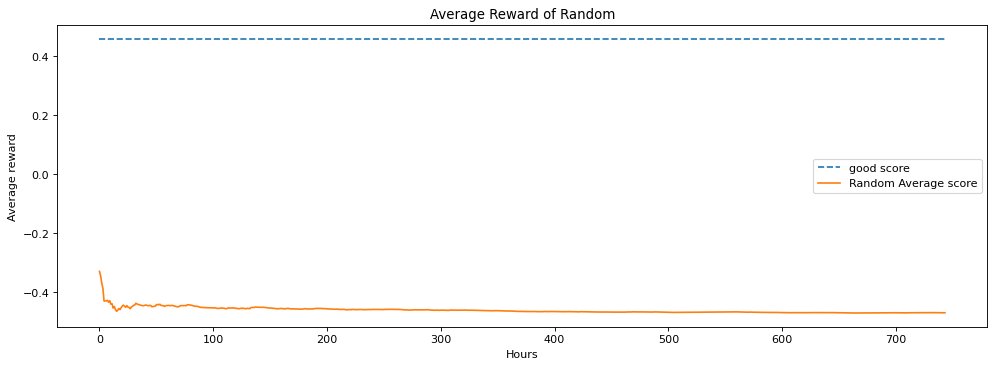

Hours:743 Reward after a month:-349.66


In [10]:
hours = 24 * 31

num_runs = 100
all_averages = []
T = []
perVsuggested = []
for run in tqdm(range(num_runs)):
    testPatient = Patient(20, True)
    scores = [0]
    averages = []
    total_reward = 0
    for h in range(0, hours):
    #     state = testPatient.reset()

        prompt = random.choice([0,1])
        activity_length = random.choice([0,1])
        action = (prompt, activity_length)
        state, reward= testPatient.step(action)
        total_reward+=reward
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (h + 1))
        
    perVsuggested.append(sum(testPatient.activity_performed)/sum(testPatient.activity_suggested) )
    all_averages.append(averages)
    T.append(total_reward)
    
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([goodAverage for _ in range(hours)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Random Average score"])
plt.title("Average Reward of Random")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

print('Hours:{} Reward after a month:{}'.format(h, np.mean(T)))

In [11]:
sum(testPatient.activity_performed)

0

In [12]:
sum(testPatient.activity_suggested)

375

# Model Free Approach

## Bandit

In [13]:
testPatient2 = Patient(20, True)

In [14]:
testPatient2.__dict__.keys()

dict_keys(['behaviour_threshold', 'has_family', 'week_days', 'hours', 'activity_suggested', 'activity_performed', 'time_of_the_day', 'day_of_the_week', 'motion_activity_list', 'awake_list', 'last_activity_score', 'location', 'valence', 'arousal', 'cognitive_load'])

In [15]:
promptN = 2 # yes/no 0 1
difficultyN = 2 # easy /dificult 0 1
lengthN = 2 # short/ long 0 1
actionN = 4

time_of_the_day = 4 # morning, midday, evening, night
day_of_the_week = 2 # week day, weekend
activity_score = 2# low/ high
location = 2 # home/ other
sleeping = 2 # yes/no
valence = 2 # positive/negative
arousal = 2 # low/high
motion = 2 #stationary, walking
cognitive_load = 2 # low/ high

q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])

In [16]:
 actions = np.array([[0, 1], [2, 3]])

In [17]:
actions.shape

(2, 2)

In [18]:
def class2action(a):
    # A 3-D array, shape-(2, 2)
    actions = np.array([[0, 1], [2, 3]])
    x, y =  np.where(actions == a)
    return x[0], y[0]

In [19]:
def action2class(a):
    actions = np.array([[0, 1], [2, 3]])
    return actions[a[0], a[1]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


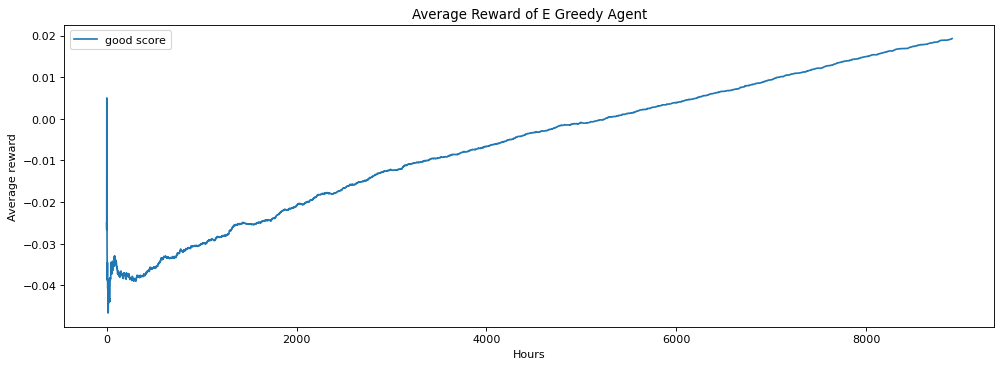

Hours:8904 Reward after a year :171.63


In [27]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7], next_state[8]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

In [28]:
testPatient2.activity_suggested

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
testPatient2.activity_performed

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
np.sum(total_rewardQL)

922

In [31]:
testPatient2.activity_suggested


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
testPatient2.activity_performed

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

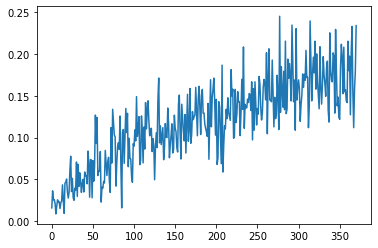

In [33]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

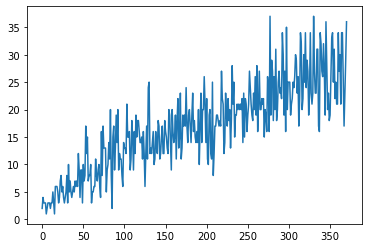

In [34]:
plt.plot(np.sum(P, axis=0))
# plt.plot(np.sum(S, axis=0))

In [72]:
31 * 12

372

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


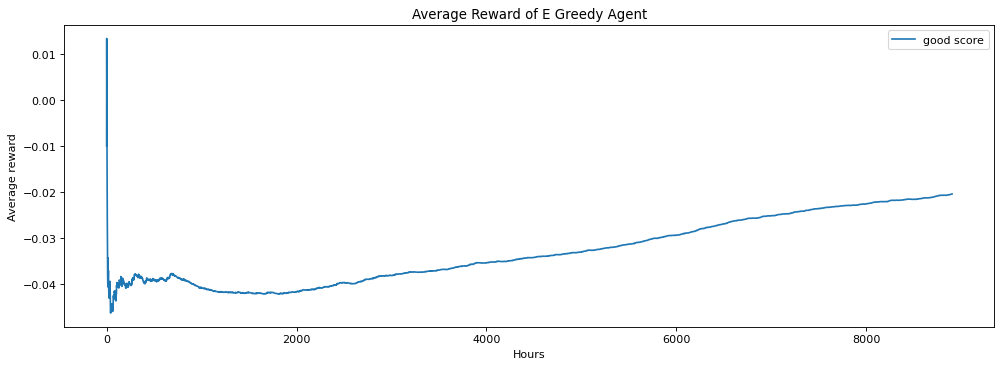

Hours:8904 Reward after a year :-182.26


In [35]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
#         testPatient2.reset()
#         state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7], next_state[8]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

In [39]:
sum(testPatient2.activity_suggested), sum(testPatient2.activity_performed)


(443, 35)

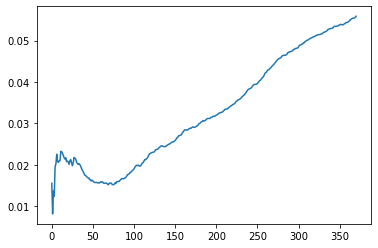

In [40]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s]


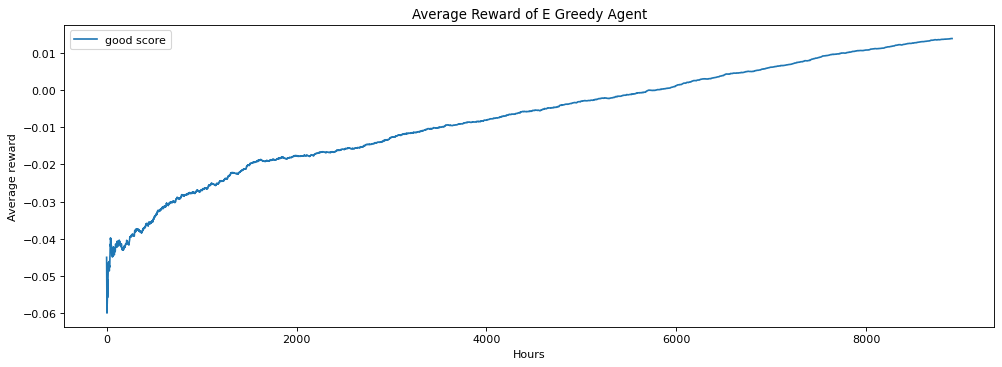

Hours:8904 Reward after a year :123.77


In [41]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

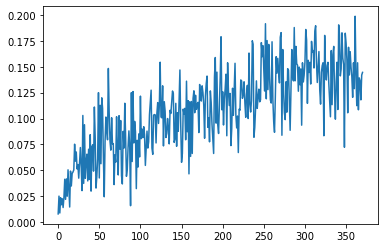

In [42]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


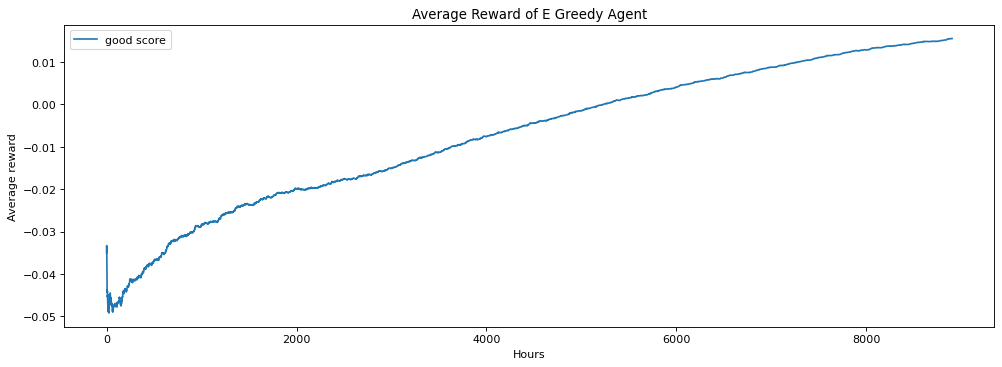

Hours:8904 Reward after a year :138.17


In [43]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

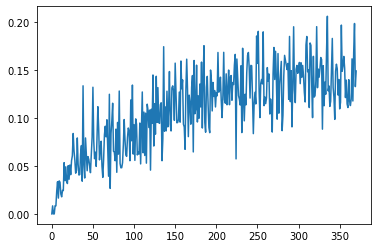

In [44]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


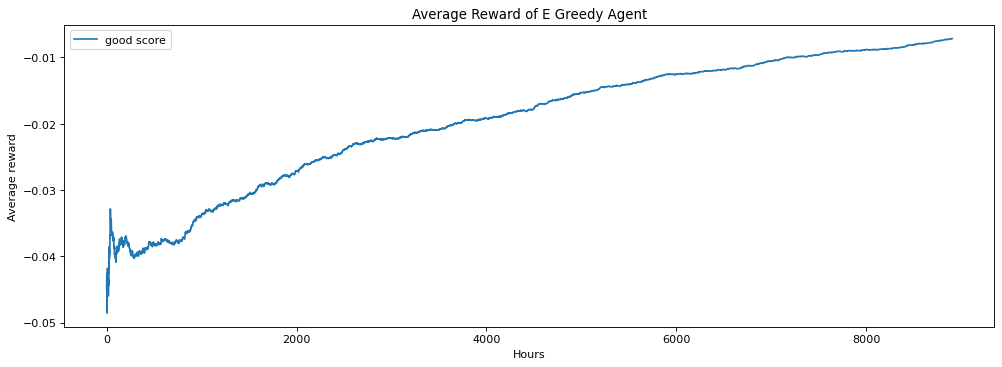

Hours:8904 Reward after a year :-63.7


In [45]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,sleeping,valence,arousal,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

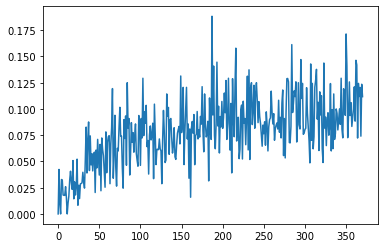

In [46]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


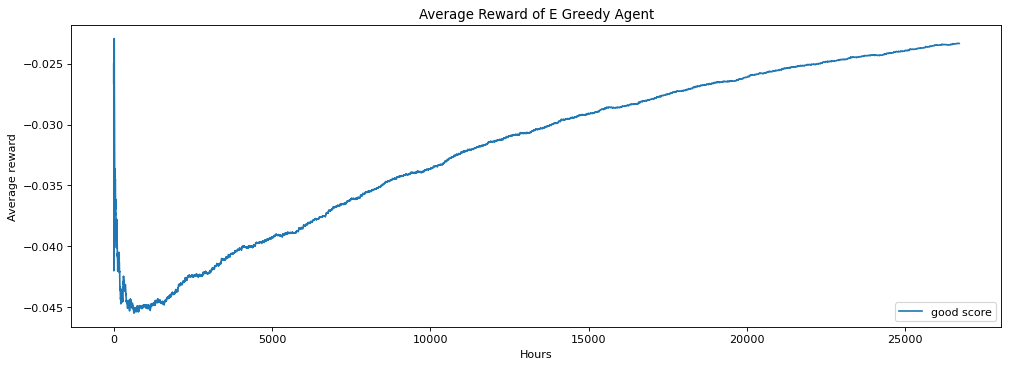

Hours:26712 Reward after a year :-623.62


In [49]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    Maria = Patient(20, True)
    John = Patient(18, False)
    Frank = Patient(25, True)
    
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.6
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        
        for testPatient2 in [Maria, John, Frank]:
            testPatient2.reset()
            state = testPatient2._get_current_state()
            day_reward = 0

            for h in range(0, 24):

                if random.uniform(0, 1) < epsilon:
                        # Explore action space
                    prompt = random.choice([0,1])
                    activity_length = random.choice([0,1])
                    action = (prompt, activity_length )

                    next_state, reward = testPatient2.step(action) 
                    action = action2class(action)
    #                 print(action)
                else:
                    action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                    a = class2action(action)
                    next_state, reward = testPatient2.step(a) 

                day_reward +=reward 
                total_reward +=reward 
                old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
                next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                              next_state[6], next_state[7], next_state[8]])
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
                j = j + 1
                total_rewardQL.append(reward)
                state = next_state
                scores.append(scores[-1] + reward)
                averages.append(scores[-1] / (j + 1))
            total_As.append(sum(testPatient2.activity_suggested))
            total_P.append(sum(testPatient2.activity_performed))

            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

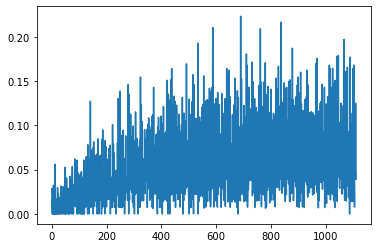

In [51]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.89it/s]


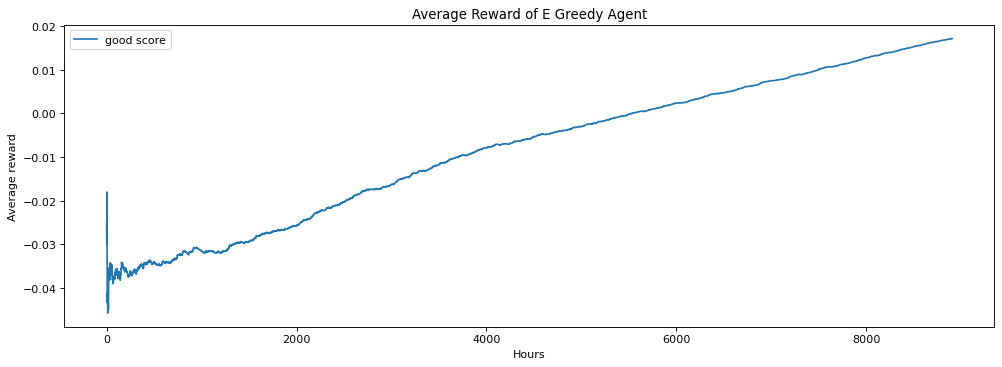

Hours:8904 Reward after a year :152.86


In [52]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.2
    gamma = 0.1
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7], next_state[8]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

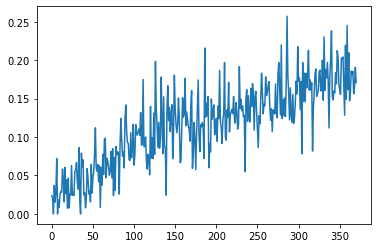

In [53]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


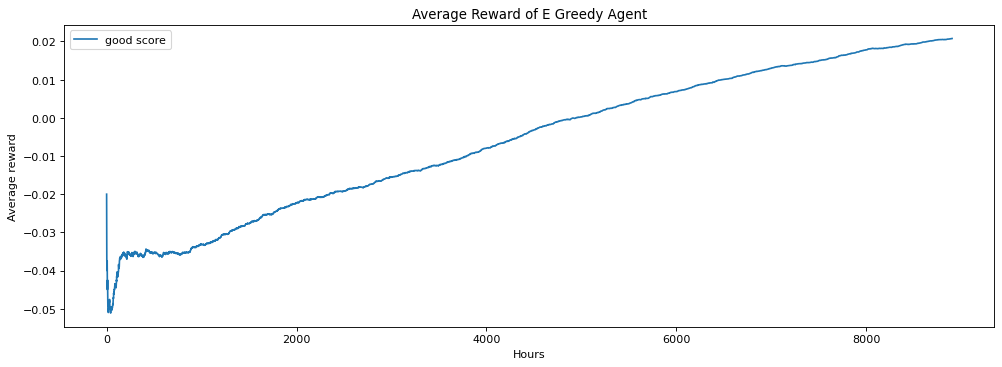

Hours:8904 Reward after a year :184.99


In [54]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.6
    gamma = 0.1
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7], next_state[8]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

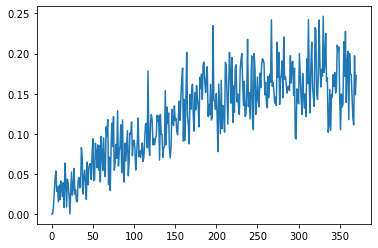

In [55]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


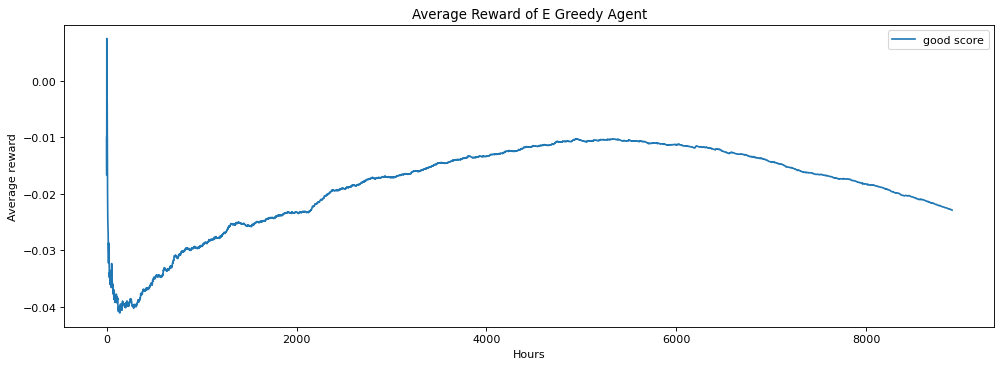

Hours:8904 Reward after a year :-203.93


In [61]:
num_runs = 100
all_averages = []
perVsuggested = []
S = []
P = []
T = []
for run in tqdm(range(num_runs)):
    testPatient2 = Patient(20, True)
    q_table = np.zeros([time_of_the_day, day_of_the_week,activity_score,location, sleeping,valence,arousal,motion,cognitive_load, actionN ])
    # Hyperparameters
    alpha = 0.6
    gamma = 0.01
    epsilon = 0.1
    total_reward =0
    # For plotting metrics
    all_epochs = []
    total_rewardQL = []
    state = testPatient2._get_current_state()
    days = 31 * 12
    scores = [0]
    averages = []
    total_As = []
    total_P = []
    j = 0
    for i in range(1, days):
        testPatient2.reset()
        state = testPatient2._get_current_state()
        day_reward = 0
        
        for h in range(0, 24):

            if random.uniform(0, 1) < epsilon:
                    # Explore action space
                prompt = random.choice([0,1])
                activity_length = random.choice([0,1])
                action = (prompt, activity_length )

                next_state, reward = testPatient2.step(action) 
                action = action2class(action)
#                 print(action)
            else:
                action  = np.argmax(q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8]]) # Exploit learned values
                a = class2action(action)
                next_state, reward = testPatient2.step(a) 

            day_reward +=reward 
            total_reward +=reward 
            old_value = q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action]
            next_max = np.max(q_table[next_state[0], next_state[1],next_state[2], next_state[3],next_state[4], next_state[5],
                                          next_state[6], next_state[7], next_state[8]])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state[0],state[1], state[2],state[3], state[4],state[5], state[6],state[7],state[8], action] = new_value
            j = j + 1
            total_rewardQL.append(reward)
            state = next_state
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (j + 1))
        total_As.append(sum(testPatient2.activity_suggested))
        total_P.append(sum(testPatient2.activity_performed))
            
            
#     perVsuggested.append(sum(testPatient2.activity_performed)/sum(testPatient2.activity_suggested) )
    all_averages.append(averages)
    S.append(total_As)
    P.append(total_P)
    T.append(total_reward)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
# plt.plot([goodAverage for _ in range(days *24)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["good score", "Average score"])
plt.title("Average Reward of E Greedy Agent")
plt.xlabel("Hours")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
print('Hours:{} Reward after a year :{}'.format(j, np.mean(T)))

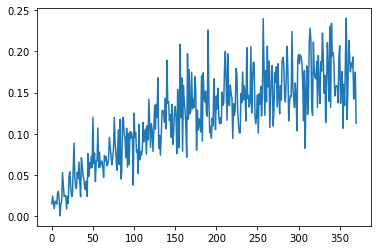

In [57]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))

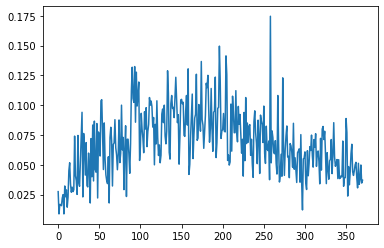

In [62]:
plt.plot(np.sum(P, axis=0)/ np.sum(S, axis=0))